In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import sys

sys.path.insert(0, str(Path.cwd().parent))

from cogwheel import data, gw_utils, gw_plotting, utils
from dot_pe import inference, waveform_banks, config
from dot_pe.zoom import zoom_iteration, zoom
from dot_pe.utils import load_intrinsic_samples_from_rundir
from dot_pe.power_law_mass_prior import PowerLawIntrinsicIASPrior
from scipy.stats import multivariate_normal, norm
from matplotlib.lines import Line2D
import pandas as pd

NOTEBOOK_OUTPUT_ROOT = Path("notebooks") / "iterative_zoom"
NOTEBOOK_OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)


# Zoom Iteration Demo

This notebook demonstrates the zoom iteration workflow: creating an injection, building an initial bank, running inference, and performing zoom iterations to improve sampling efficiency.


## Step 1: Create Injection

Create a high SNR injection with low luminosity distance for testing.


In [ ]:
# Injection setup
injection_event_name = "zoom_example_event"

injection_dir = NOTEBOOK_OUTPUT_ROOT / "injection"
injection_dir.mkdir(parents=True, exist_ok=True)

injection_event_path = injection_dir / f"{injection_event_name}.npz"

injection_event_kwargs = dict(
    eventname=injection_event_name,
    detector_names="HL",
    duration=120.0,
    asd_funcs=["asd_H_O3", "asd_L_O3"],
    tgps=0.0,
    fmax=1600.0,
    seed=20250311,
)

injection_mchirp = 30.0
injection_mass_ratio = 0.5
injection_m1, injection_m2 = gw_utils.mchirpeta_to_m1m2(
    injection_mchirp, gw_utils.q_to_eta(injection_mass_ratio)
)

injection_parameters = dict(
    m1=injection_m1,
    m2=injection_m2,
    ra=0.5,
    dec=0.5,
    iota=np.pi / 3,
    psi=1.0,
    phi_ref=12.0,
    s1z=0.6,
    s2z=0.6,
    s1x_n=0.1,
    s1y_n=0.2,
    s2x_n=0.3,
    s2y_n=-0.2,
    l1=0.0,
    l2=0.0,
    tgps=0.0,
    f_ref=50.0,
    d_luminosity=1.5e3,
    t_geocenter=0.0,
)

injection_waveform_model = "IMRPhenomXPHM"

In [3]:
# Generate and save injection
injection_event_data = data.EventData.gaussian_noise(**injection_event_kwargs)
injection_event_data.inject_signal(injection_parameters, injection_waveform_model)

injection_event_data.to_npz(filename=injection_event_path, overwrite=True)
print(f"Injection saved to {injection_event_path}")

injection_log_likelihood = (
    injection_event_data.injection["d_h"]
    - 0.5 * injection_event_data.injection["h_h"]
).sum()
print(f"Injection SNR^2 = {2 * injection_log_likelihood:.3g}")
print(f"Injection SNR = {np.sqrt(2 * injection_log_likelihood):.3g}")


Injection saved to injection/zoom_example_event.npz
Injection SNR^2 = 274
Injection SNR = 16.6


## Step 2: Create Initial Bank

Create a wide prior bank with 2^16 samples for initial inference.


In [ ]:
# Initial bank setup
initial_bank_dir = NOTEBOOK_OUTPUT_ROOT / "bank"
initial_bank_dir.mkdir(parents=True, exist_ok=True)

initial_waveform_dir = initial_bank_dir / "waveforms"
initial_waveform_dir.mkdir(exist_ok=True)

initial_bank_size = 2**16
initial_mchirp_min = 15.0
initial_mchirp_max = 65.0
initial_q_min = 0.2
initial_f_ref = 50.0
initial_fbin = config.DEFAULT_FBIN
initial_approximant = "IMRPhenomXPHM"
initial_bank_seed = 1701

initial_bank_samples_path = initial_bank_dir / "intrinsic_sample_bank.feather"
initial_bank_config_path = initial_bank_dir / "bank_config.json"

initial_powerlaw_prior_kwargs = dict(
    mchirp_range=(initial_mchirp_min, initial_mchirp_max),
    q_min=initial_q_min,
    f_ref=initial_f_ref,
)

initial_bank_columns = [
    "m1",
    "m2",
    "s1z",
    "s1x_n",
    "s1y_n",
    "s2z",
    "s2x_n",
    "s2y_n",
    "iota",
    "log_prior_weights",
]


In [5]:
# Build initial bank
print("Generating samples for initial bank...")
initial_powerlaw_prior = PowerLawIntrinsicIASPrior(**initial_powerlaw_prior_kwargs)

initial_powerlaw_samples = initial_powerlaw_prior.generate_random_samples(
    initial_bank_size, seed=initial_bank_seed, return_lnz=False
)
print(f"Generated {len(initial_powerlaw_samples):,} samples")

initial_powerlaw_samples["mchirp"] = gw_utils.m1m2_to_mchirp(
    initial_powerlaw_samples["m1"], initial_powerlaw_samples["m2"]
)
initial_powerlaw_samples["lnq"] = np.log(
    initial_powerlaw_samples["m2"] / initial_powerlaw_samples["m1"]
)
initial_powerlaw_samples["chieff"] = gw_utils.chieff(
    *initial_powerlaw_samples[["m1", "m2", "s1z", "s2z"]].values.T
)

initial_bank_mchirp_values = initial_powerlaw_samples["mchirp"].values
initial_powerlaw_samples["log_prior_weights"] = 1.7 * np.log(initial_bank_mchirp_values)

initial_powerlaw_samples[initial_bank_columns].to_feather(initial_bank_samples_path)
print(f"Saved samples to {initial_bank_samples_path}")

initial_bank_config = {
    "bank_size": initial_bank_size,
    "mchirp_min": initial_mchirp_min,
    "mchirp_max": initial_mchirp_max,
    "q_min": initial_q_min,
    "f_ref": initial_f_ref,
    "fbin": initial_fbin.tolist(),
    "approximant": initial_approximant,
    "seed": initial_bank_seed,
}

with open(initial_bank_config_path, "w") as fp:
    json.dump(obj=initial_bank_config, fp=fp, indent=4)
print(f"Saved bank config to {initial_bank_config_path}")

print("Generating waveforms for initial bank...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=initial_bank_samples_path,
    bank_config_path=initial_bank_config_path,
    waveform_dir=initial_waveform_dir,
    n_pool=4,
    blocksize=4096,
    approximant=initial_approximant,
)
print(f"Initial bank created at {initial_bank_dir}")


Generating samples for initial bank...


2025-11-26 10:55:57,023 - INFO - dot_pe.waveform_banks started at Wed Nov 26 10:55:57 2025


Generated 65,536 samples
Saved samples to bank/intrinsic_sample_bank.feather
Saved bank config to bank/bank_config.json
Generating waveforms for initial bank...


2025-11-26 10:56:23,035 - INFO - dot_pe.waveform_banks finished after 26 seconds (0.434 minutes).


Initial bank created at bank


## Step 3: Run Initial Inference

Run inference with the initial bank and display summary results.


In [ ]:
# Initial inference setup
initial_inference_event_data = data.EventData.from_npz(filename=injection_event_path)

initial_inference_dir = (
    NOTEBOOK_OUTPUT_ROOT / "inference_runs" / initial_inference_event_data.eventname
)
initial_inference_dir.mkdir(parents=True, exist_ok=True)

initial_inference_kwargs = dict(
    event_dir=str(initial_inference_dir),
    event=initial_inference_event_data,
    bank_folder=str(initial_bank_dir),
    n_int=initial_bank_size,
    n_ext=2048,
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=1337,
    size_limit=10**6,
    draw_subset=True,
)


In [7]:
# Run initial inference
initial_rundir = inference.run(**initial_inference_kwargs)
print(f"Inference complete. Results in {initial_rundir}")

initial_summary_path = Path(initial_rundir) / "summary_results.json"
initial_run_summary = utils.read_json(initial_summary_path)
print("\nSummary results:")
print(f"  n_effective: {initial_run_summary['n_effective']:.2f}")
print(f"  n_effective_i: {initial_run_summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {initial_run_summary['n_effective_e']:.2f}")


Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 64/64 [02:17<00:00,  2.14s/it]


535 intrinsic samples selected.
Generating extrinsic samples...


2025-11-26 10:59:06 - Getting 16 MarginalizationInfo objects.
Marginalization objects: 100%|██████████| 16/16 [00:01<00:00,  8.52obj/s, batches=1/17, accepted=16/16]
2025-11-26 10:59:08 - MarginalizationInfo object created!
2025-11-26 10:59:08 - Saving MarginalizationInfo object to inference_runs/zoom_example_event/run_0.


Creating 1 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 2/2 [00:10<00:00,  5.49s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 0.0406 seconds.
Saving samples to file...
Samples saved to:
 inference_runs/zoom_example_event/run_0/samples.feather
Inference complete. Results in inference_runs/zoom_example_event/run_0

Summary results:
  n_effective: 569.64
  n_effective_i: 11.52
  n_effective_e: 189.56


## Step 4: First Zoom Iteration

Fit a Gaussian zoomer to the top-weighted samples, create a focused bank, and run inference.


In [8]:
# Load intrinsic samples from initial inference
iter1_post_samples = load_intrinsic_samples_from_rundir(initial_rundir)
iter1_sample_weights = iter1_post_samples["weights"].values

# Select top weight samples for zoomer fit
iter1_weight_threshold = 0.9
iter1_sorted_idx = np.argsort(iter1_sample_weights)[::-1]
iter1_cumsum_weights = np.cumsum(iter1_sample_weights[iter1_sorted_idx])
iter1_n_selected = max(
    np.searchsorted(iter1_cumsum_weights, iter1_weight_threshold) + 1, 20
)
iter1_selected_idx = iter1_sorted_idx[:iter1_n_selected]
iter1_top_samples = iter1_post_samples.iloc[iter1_selected_idx]
iter1_top_weights = iter1_sample_weights[iter1_selected_idx]

print(
    f"Selected {iter1_n_selected} samples (sum of weights: {iter1_top_weights.sum():.3f})"
)


Selected 20 samples (sum of weights: 0.925)


In [9]:
# Fit zoomer with n_sig=1
iter1_prior_kwargs = {
    "mchirp_range": (initial_mchirp_min, initial_mchirp_max),
    "q_min": initial_q_min,
    "f_ref": initial_f_ref,
}
iter1_zoomer, iter1_cond_sampler, iter1_bounds = zoom_iteration.fit_zoomer(
    iter1_top_samples, iter1_top_weights, iter1_prior_kwargs, seed=9731, n_sig=1
)

print(f"Zoomer mean: {iter1_zoomer.mean}")
print("Zoomer covariance matrix:")
print(iter1_zoomer.cov)


Zoomer mean: [30.83683047 -0.66658044  0.62074589]
Zoomer covariance matrix:
[[12.99783998  1.40786121  1.16351206]
 [ 1.40786121  0.54684778  0.19363681]
 [ 1.16351206  0.19363681  0.11939984]]


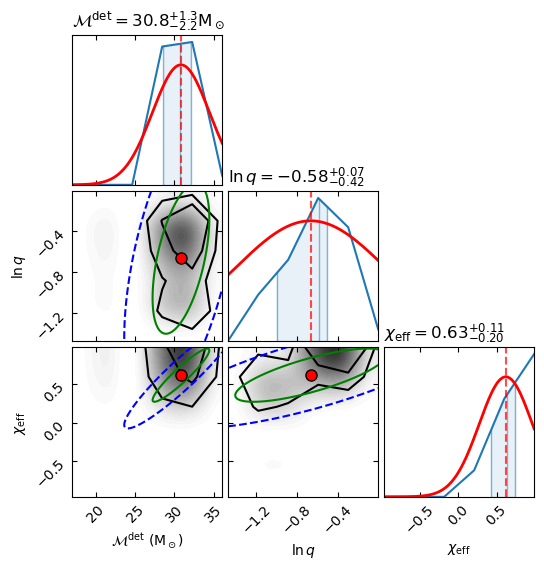

In [10]:
# Create corner plot with Gaussian overlay
iter1_corner_plot = gw_plotting.CornerPlot(
    iter1_post_samples, params=["mchirp", "lnq", "chieff"]
)
iter1_corner_plot.plot()

# Overlay 1D Gaussians on diagonal axes
iter1_corner_params = ["mchirp", "lnq", "chieff"]
for i, _ in enumerate(iter1_corner_params):
    ax = iter1_corner_plot.axes[i, i]
    mean_1d = iter1_zoomer.mean[i]
    std_1d = np.sqrt(iter1_zoomer.cov[i, i])

    xlim = ax.get_xlim()
    x = np.linspace(xlim[0], xlim[1], 200)

    rv_1d = norm(mean_1d, std_1d)
    pdf_1d = rv_1d.pdf(x)

    ylim = ax.get_ylim()
    pdf_1d_scaled = pdf_1d * (ylim[1] - ylim[0]) / pdf_1d.max() * 0.8

    ax.plot(x, pdf_1d_scaled + ylim[0], "r-", linewidth=2, label="Fitted Gaussian")
    ax.axvline(mean_1d, color="red", linestyle="--", linewidth=1.5, alpha=0.7)

# Overlay 2D Gaussian contours and mean on off-diagonal axes
iter1_corner_pairs = [
    (("mchirp", "lnq"), (0, 1)),
    (("mchirp", "chieff"), (0, 2)),
    (("lnq", "chieff"), (1, 2)),
]

for (_, _), (i1, i2) in iter1_corner_pairs:
    ax = iter1_corner_plot.axes[i2, i1]
    mean_2d = iter1_zoomer.mean[[i1, i2]]
    cov_2d = iter1_zoomer.cov[[i1, i2], :][:, [i1, i2]]

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    rv = multivariate_normal(mean_2d, cov_2d)
    Z = rv.pdf(pos)

    levels = [rv.pdf(mean_2d) * np.exp(-0.5 * v**2) for v in [2, 1]]

    ax.contour(
        X, Y, Z, levels=[levels[0]], colors=["blue"], linestyles=["--"], linewidths=1.5
    )
    ax.contour(
        X, Y, Z, levels=[levels[1]], colors=["green"], linestyles=["-"], linewidths=1.5
    )
    ax.plot(
        mean_2d[0], mean_2d[1], "ro", markersize=8, markeredgecolor="black", markeredgewidth=1
    )

plt.show()


In [ ]:
# Zoom iteration 1 bank setup
iter1_zoom_dir = NOTEBOOK_OUTPUT_ROOT / "zoom" / "iter1"
iter1_zoom_dir.mkdir(parents=True, exist_ok=True)

iter1_bank_dir = iter1_zoom_dir / "bank"
iter1_bank_dir.mkdir(parents=True, exist_ok=True)
iter1_bank_samples_path = iter1_bank_dir / "intrinsic_sample_bank.feather"
iter1_bank_config_path = iter1_bank_dir / "bank_config.json"
iter1_bank_waveform_dir = iter1_bank_dir / "waveforms"
iter1_bank_waveform_dir.mkdir(parents=True, exist_ok=True)

iter1_zoom_bank_size = 4096
iter1_zoom_bank_seed = 3141


In [12]:
# Create new bank using zoomer (small bank of 4096 samples)
iter1_zoom_bank = zoom_iteration.draw_from_zoomer(
    iter1_zoomer,
    iter1_cond_sampler,
    iter1_bounds,
    n_samples=iter1_zoom_bank_size,
    seed=iter1_zoom_bank_seed,
)

iter1_zoom_bank.to_feather(iter1_bank_samples_path)

iter1_bank_config = utils.read_json(initial_bank_config_path)
iter1_bank_config.update({"bank_size": len(iter1_zoom_bank)})
with open(iter1_bank_config_path, "w") as fp:
    json.dump(obj=iter1_bank_config, fp=fp, indent=4)

print(f"Created bank at {iter1_bank_samples_path} ({len(iter1_zoom_bank)} samples)")

waveform_banks.create_waveform_bank_from_samples(
    samples_path=iter1_bank_samples_path,
    bank_config_path=iter1_bank_config_path,
    waveform_dir=iter1_bank_waveform_dir,
    n_pool=4,
    blocksize=4096,
    approximant=initial_approximant,
)
print("Waveforms generated")


2025-11-26 10:59:22,768 - INFO - dot_pe.waveform_banks started at Wed Nov 26 10:59:22 2025
2025-11-26 10:59:22,768 - INFO - dot_pe.waveform_banks started at Wed Nov 26 10:59:22 2025


Created bank at zoom/iter1/bank/intrinsic_sample_bank.feather (4096 samples)


2025-11-26 10:59:32,043 - INFO - dot_pe.waveform_banks finished after 9.28 seconds (0.155 minutes).
2025-11-26 10:59:32,043 - INFO - dot_pe.waveform_banks finished after 9.28 seconds (0.155 minutes).


Waveforms generated


In [13]:
# Zoom iteration 1 inference setup
iter1_extrinsic_samples_path = Path(initial_rundir) / "extrinsic_samples.feather"

iter1_inference_kwargs = dict(
    event_dir=str(iter1_zoom_dir),
    event=initial_inference_event_data,
    bank_folder=str(iter1_bank_dir),
    n_int=len(iter1_zoom_bank),
    n_ext=2048,
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=1618,
    size_limit=10**6,
    draw_subset=True,
    n_draws=1,
    extrinsic_samples=str(iter1_extrinsic_samples_path),
)


In [14]:
# Run zoom iteration 1 inference
iter1_rundir = inference.run(**iter1_inference_kwargs)
print(f"Zoom iteration 1 inference complete. Results in {iter1_rundir}")

iter1_summary_path = Path(iter1_rundir) / "summary_results.json"
iter1_run_summary = utils.read_json(iter1_summary_path)
print("\nZoom iteration 1 results:")
print(f"  n_effective: {iter1_run_summary['n_effective']:.2f}")
print(f"  n_effective_i: {iter1_run_summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {iter1_run_summary['n_effective_e']:.2f}")


Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


1537 intrinsic samples selected.
Loading extrinsic samples from file...
Creating 2 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 4/4 [00:24<00:00,  6.17s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 0.00917 seconds.
Saving samples to file...
Samples saved to:
 zoom/iter1/run_0/samples.feather
Zoom iteration 1 inference complete. Results in zoom/iter1/run_0

Zoom iteration 1 results:
  n_effective: 2600.61
  n_effective_i: 15.28
  n_effective_e: 305.37


## Step 5: Efficiency Calculation

Calculate efficiency and extrapolate to 2^16 bank size.


In [15]:
# Calculate efficiency
iter1_effective_intrinsic = iter1_run_summary["n_effective_i"]
iter1_bank_size = len(iter1_zoom_bank)
iter1_efficiency = iter1_effective_intrinsic / iter1_bank_size

print(f"Zoom iteration 1 efficiency: {iter1_efficiency:.4f}")
print(f"  n_effective_i: {iter1_effective_intrinsic:.2f}")
print(f"  bank_size: {iter1_bank_size}")

# Extrapolate to 2^16
iter1_extrapolated_effective = iter1_efficiency * 2**16
print(
    f"\nExtrapolated n_effective_i for 2^16 bank: {iter1_extrapolated_effective:.0f}"
)


Zoom iteration 1 efficiency: 0.0037
  n_effective_i: 15.28
  bank_size: 4096

Extrapolated n_effective_i for 2^16 bank: 244


## Step 6: Second Zoom Iteration

Fit a new zoomer from iteration 1 results, compare with iteration 1 zoomer, create a small bank, and run a small PE to check convergence.


In [16]:
# Load samples from first zoom iteration
iter2_post_samples = load_intrinsic_samples_from_rundir(iter1_rundir)
iter2_sample_weights = iter2_post_samples["weights"].values

iter2_weight_threshold = 0.9
iter2_sorted_idx = np.argsort(iter2_sample_weights)[::-1]
iter2_cumsum_weights = np.cumsum(iter2_sample_weights[iter2_sorted_idx])
iter2_n_selected = np.searchsorted(iter2_cumsum_weights, iter2_weight_threshold) + 1
iter2_selected_idx = iter2_sorted_idx[:iter2_n_selected]
iter2_top_samples = iter2_post_samples.iloc[iter2_selected_idx]
iter2_top_weights = iter2_sample_weights[iter2_selected_idx]

print(f"Selected {iter2_n_selected} samples for iteration 2")


Selected 97 samples for iteration 2


In [17]:
# Fit iteration 2 zoomer
iter2_zoomer, iter2_cond_sampler, iter2_bounds = zoom_iteration.fit_zoomer(
    iter2_top_samples, iter2_top_weights, iter1_prior_kwargs, seed=496351, n_sig=1
)

print(f"\nZoomer 1 mean: {iter1_zoomer.mean}")
print(f"Zoomer 2 mean: {iter2_zoomer.mean}")



Zoomer 1 mean: [30.83683047 -0.66658044  0.62074589]
Zoomer 2 mean: [30.7790953  -0.75131758  0.62009637]


In [18]:
# Compare two Gaussians using Hellinger distance
iter1_zoomer_samples, _ = iter1_zoomer.sample(1000, bounds=iter1_bounds)
iter2_zoomer_samples, _ = iter2_zoomer.sample(1000, bounds=iter2_bounds)

iter12_hellinger_distance = zoom_iteration.hellinger_distance(
    iter1_zoomer_samples,
    iter2_zoomer_samples,
    iter1_zoomer.distribution.logpdf,
    iter2_zoomer.distribution.logpdf,
)

print(f"Hellinger distance between zoomer 1 and 2: {iter12_hellinger_distance:.4f}")


Hellinger distance between zoomer 1 and 2: 0.3272


In [ ]:
# Zoom iteration 2 (small bank) setup
iter2_zoom_dir = NOTEBOOK_OUTPUT_ROOT / "zoom" / "iter2"
iter2_zoom_dir.mkdir(parents=True, exist_ok=True)

iter2_small_bank_dir = iter2_zoom_dir / "bank"
iter2_small_bank_dir.mkdir(parents=True, exist_ok=True)
iter2_small_bank_samples_path = iter2_small_bank_dir / "intrinsic_sample_bank.feather"
iter2_small_bank_config_path = iter2_small_bank_dir / "bank_config.json"
iter2_small_waveform_dir = iter2_small_bank_dir / "waveforms"
iter2_small_waveform_dir.mkdir(parents=True, exist_ok=True)

iter2_small_bank_size = 4096
iter2_small_bank_seed = 404


In [20]:
# Create small bank (4096 samples) from zoomer-conditional-sampling
print("Creating small bank (4096 samples) from zoomer...")
iter2_small_bank = zoom_iteration.draw_from_zoomer(
    iter2_zoomer,
    iter2_cond_sampler,
    iter2_bounds,
    n_samples=iter2_small_bank_size,
    seed=iter2_small_bank_seed,
)

iter2_small_bank.to_feather(iter2_small_bank_samples_path)

iter2_small_bank_config = {
    "bank_size": len(iter2_small_bank),
    "mchirp_min": initial_mchirp_min,
    "mchirp_max": initial_mchirp_max,
    "q_min": initial_q_min,
    "f_ref": initial_f_ref,
    "fbin": initial_fbin.tolist(),
    "approximant": initial_approximant,
    "seed": iter2_small_bank_seed,
}
with open(iter2_small_bank_config_path, "w") as fp:
    json.dump(obj=iter2_small_bank_config, fp=fp, indent=4)
print(
    f"Created bank at {iter2_small_bank_samples_path} ({len(iter2_small_bank)} samples)"
)

print("Generating waveforms...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=iter2_small_bank_samples_path,
    bank_config_path=iter2_small_bank_config_path,
    waveform_dir=iter2_small_waveform_dir,
    n_pool=4,
    blocksize=4096,
    approximant=initial_approximant,
)
print("Waveforms generated")


Creating small bank (4096 samples) from zoomer...


2025-11-26 11:00:17,588 - INFO - dot_pe.waveform_banks started at Wed Nov 26 11:00:17 2025
2025-11-26 11:00:17,588 - INFO - dot_pe.waveform_banks started at Wed Nov 26 11:00:17 2025
2025-11-26 11:00:17,588 - INFO - dot_pe.waveform_banks started at Wed Nov 26 11:00:17 2025


Created bank at zoom/iter2/bank/intrinsic_sample_bank.feather (4096 samples)
Generating waveforms...


2025-11-26 11:00:26,582 - INFO - dot_pe.waveform_banks finished after 8.99 seconds (0.15 minutes).
2025-11-26 11:00:26,582 - INFO - dot_pe.waveform_banks finished after 8.99 seconds (0.15 minutes).
2025-11-26 11:00:26,582 - INFO - dot_pe.waveform_banks finished after 8.99 seconds (0.15 minutes).


Waveforms generated


In [21]:
# Zoom iteration 2 small inference setup
iter2_small_extrinsic_samples_path = Path(iter1_rundir) / "extrinsic_samples.feather"

iter2_small_inference_kwargs = dict(
    event_dir=str(iter2_zoom_dir),
    event=initial_inference_event_data,
    bank_folder=str(iter2_small_bank_dir),
    n_int=len(iter2_small_bank),
    n_ext=2048,
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=2001,
    size_limit=10**6,
    draw_subset=True,
    n_draws=1,
    extrinsic_samples=str(iter2_small_extrinsic_samples_path),
)


In [22]:
# Run zoom iteration 2 small PE
iter2_small_rundir = inference.run(**iter2_small_inference_kwargs)
print(f"Zoom iteration 2 small PE complete. Results in {iter2_small_rundir}")

iter2_small_summary_path = Path(iter2_small_rundir) / "summary_results.json"
iter2_small_run_summary = utils.read_json(iter2_small_summary_path)
print("\nZoom iteration 2 small PE results:")
print(f"  n_effective: {iter2_small_run_summary['n_effective']:.2f}")
print(f"  n_effective_i: {iter2_small_run_summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {iter2_small_run_summary['n_effective_e']:.2f}")
print(f"  Hellinger distance: {iter12_hellinger_distance:.4f}")


Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


1349 intrinsic samples selected.
Loading extrinsic samples from file...
Creating 2 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 4/4 [00:23<00:00,  5.82s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 0.00924 seconds.
Saving samples to file...
Samples saved to:
 zoom/iter2/run_0/samples.feather
Zoom iteration 2 small PE complete. Results in zoom/iter2/run_0

Zoom iteration 2 small PE results:
  n_effective: 4835.21
  n_effective_i: 18.62
  n_effective_e: 304.41
  Hellinger distance: 0.3272


In [ ]:
# Zoom iteration 2 (large bank) setup
iter2_large_zoom_dir = NOTEBOOK_OUTPUT_ROOT / "zoom" / "iter2_large"
iter2_large_zoom_dir.mkdir(parents=True, exist_ok=True)

iter2_large_bank_dir = iter2_large_zoom_dir / "bank"
iter2_large_bank_dir.mkdir(parents=True, exist_ok=True)
iter2_large_bank_samples_path = (
    iter2_large_bank_dir / "intrinsic_sample_bank.feather"
)
iter2_large_bank_config_path = iter2_large_bank_dir / "bank_config.json"
iter2_large_waveform_dir = iter2_large_bank_dir / "waveforms"
iter2_large_waveform_dir.mkdir(parents=True, exist_ok=True)

iter2_large_bank_size = 2**16
iter2_large_bank_seed = 1984


## Step 7: Create Large Bank and Run Full PE

Create a large bank (2^16 samples) from iteration 2 zoomer and run full parameter estimation.


In [24]:
# Create large bank (2^16 samples) from zoomer-conditional-sampling
print("Creating large bank (2^16 samples) from zoomer...")
iter2_large_bank = zoom_iteration.draw_from_zoomer(
    iter2_zoomer,
    iter2_cond_sampler,
    iter2_bounds,
    n_samples=iter2_large_bank_size,
    seed=iter2_large_bank_seed,
)

iter2_large_bank.to_feather(iter2_large_bank_samples_path)

iter2_large_bank_config = {
    "bank_size": len(iter2_large_bank),
    "mchirp_min": initial_mchirp_min,
    "mchirp_max": initial_mchirp_max,
    "q_min": initial_q_min,
    "f_ref": initial_f_ref,
    "fbin": initial_fbin.tolist(),
    "approximant": initial_approximant,
    "seed": iter2_large_bank_seed,
}
with open(iter2_large_bank_config_path, "w") as fp:
    json.dump(obj=iter2_large_bank_config, fp=fp, indent=4)

print(
    f"Created bank at {iter2_large_bank_samples_path} ({len(iter2_large_bank)} samples)"
)

print("Generating waveforms...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=iter2_large_bank_samples_path,
    bank_config_path=iter2_large_bank_config_path,
    waveform_dir=iter2_large_waveform_dir,
    n_pool=4,
    blocksize=4096,
    approximant=initial_approximant,
)
print("Waveforms generated")


Creating large bank (2^16 samples) from zoomer...


2025-11-26 11:01:14,435 - INFO - dot_pe.waveform_banks started at Wed Nov 26 11:01:14 2025
2025-11-26 11:01:14,435 - INFO - dot_pe.waveform_banks started at Wed Nov 26 11:01:14 2025
2025-11-26 11:01:14,435 - INFO - dot_pe.waveform_banks started at Wed Nov 26 11:01:14 2025
2025-11-26 11:01:14,435 - INFO - dot_pe.waveform_banks started at Wed Nov 26 11:01:14 2025


Created bank at zoom/iter2_large/bank/intrinsic_sample_bank.feather (65536 samples)
Generating waveforms...


2025-11-26 11:01:39,342 - INFO - dot_pe.waveform_banks finished after 24.9 seconds (0.415 minutes).
2025-11-26 11:01:39,342 - INFO - dot_pe.waveform_banks finished after 24.9 seconds (0.415 minutes).
2025-11-26 11:01:39,342 - INFO - dot_pe.waveform_banks finished after 24.9 seconds (0.415 minutes).
2025-11-26 11:01:39,342 - INFO - dot_pe.waveform_banks finished after 24.9 seconds (0.415 minutes).


Waveforms generated


In [25]:
# Zoom iteration 2 large inference setup
iter2_large_extrinsic_samples_path = Path(iter2_small_rundir) / "extrinsic_samples.feather"

iter2_large_inference_kwargs = dict(
    event_dir=str(iter2_large_zoom_dir),
    event=initial_inference_event_data,
    bank_folder=str(iter2_large_bank_dir),
    n_int=len(iter2_large_bank),
    n_ext=2048,
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=2049,
    size_limit=10**6,
    draw_subset=True,
)


In [26]:
# Run zoom iteration 2 large PE
iter2_large_rundir = inference.run(**iter2_large_inference_kwargs)
print(f"Zoom iteration 2 large PE complete. Results in {iter2_large_rundir}")

iter2_large_summary_path = Path(iter2_large_rundir) / "summary_results.json"
iter2_large_run_summary = utils.read_json(iter2_large_summary_path)
print("\nZoom iteration 2 large PE results:")
print(f"  n_effective: {iter2_large_run_summary['n_effective']:.2f}")
print(f"  n_effective_i: {iter2_large_run_summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {iter2_large_run_summary['n_effective_e']:.2f}")


Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 64/64 [02:18<00:00,  2.16s/it]


18631 intrinsic samples selected.
Generating extrinsic samples...


2025-11-26 11:04:20 - Getting 16 MarginalizationInfo objects.
Marginalization objects: 100%|██████████| 16/16 [00:01<00:00,  9.71obj/s, batches=1/583, accepted=16/16]
2025-11-26 11:04:21 - MarginalizationInfo object created!
2025-11-26 11:04:21 - Saving MarginalizationInfo object to zoom/iter2_large/run_0.


Creating 19 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 38/38 [02:38<00:00,  4.17s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 1.11 seconds.
Saving samples to file...
Samples saved to:
 zoom/iter2_large/run_0/samples.feather
Zoom iteration 2 large PE complete. Results in zoom/iter2_large/run_0

Zoom iteration 2 large PE results:
  n_effective: 43370.45
  n_effective_i: 244.62
  n_effective_e: 253.07


## Step 8: Compare Results

Compare intrinsic samples from the initial PE run with the final zoom iteration PE run.


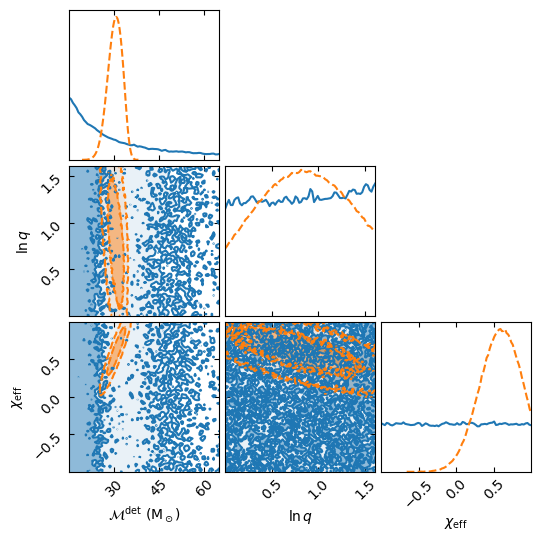

In [27]:
# Compare banks

initial_bank_dataframe = pd.read_feather(initial_bank_samples_path)
iter2_large_bank_dataframe = pd.read_feather(iter2_large_bank_samples_path)

for bank_dataframe in [initial_bank_dataframe, iter2_large_bank_dataframe]:
    bank_dataframe["mchirp"] = gw_utils.m1m2_to_mchirp(
        *bank_dataframe[["m1", "m2"]].values.T
    )
    bank_dataframe["lnq"] = np.log(
        np.divide(*bank_dataframe[["m1", "m2"]].values.T)
    )
    bank_dataframe["chieff"] = gw_utils.chieff(
        *bank_dataframe[["m1", "m2", "s1z", "s2z"]].values.T
    )
    bank_dataframe["weights"] = np.exp(bank_dataframe["log_prior_weights"])

gw_plotting.MultiCornerPlot(
    [initial_bank_dataframe, iter2_large_bank_dataframe],
    params=["mchirp", "lnq", "chieff"],
    weights_col="None",
).plot()

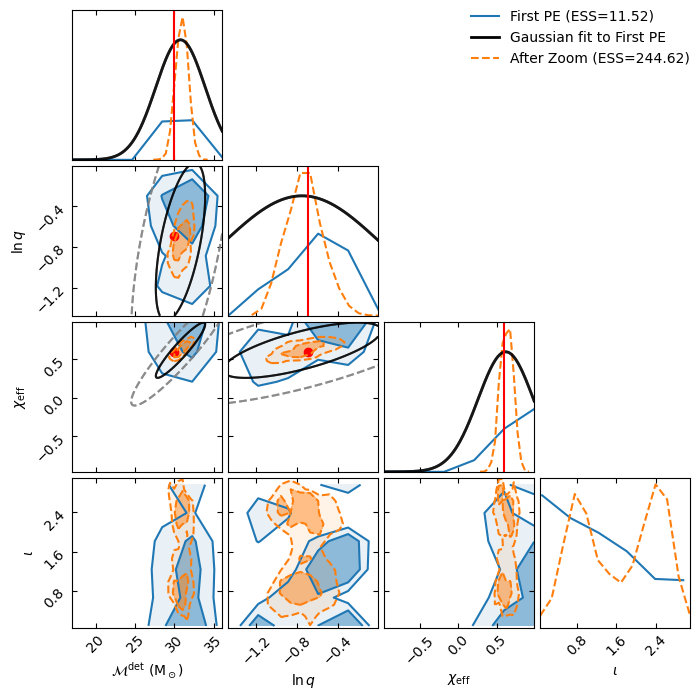

In [ ]:
# Load intrinsic samples from both PE runs
initial_run_samples = load_intrinsic_samples_from_rundir(initial_rundir)
iter2_large_run_samples = load_intrinsic_samples_from_rundir(iter2_large_rundir)

initial_effective_sample_count = initial_run_summary["n_effective_i"]
iter2_large_effective_sample_count = iter2_large_run_summary["n_effective_i"]

comparison_corner_plot = gw_plotting.MultiCornerPlot(
    [initial_run_samples, iter2_large_run_samples],
    params=["mchirp", "lnq", "chieff"],
    labels=[
        f"First PE (ESS={initial_effective_sample_count:.2f})",
        f"After Zoom (ESS={iter2_large_effective_sample_count:.2f})",
    ],
)
comparison_corner_plot.plot(
    legend_title=f"Full mchirp range {initial_mchirp_min}-{initial_mchirp_max}"
)

comparison_param_names = ["mchirp", "lnq", "chieff"]
for axis_index, _ in enumerate(comparison_param_names):
    for corner_plot in comparison_corner_plot.corner_plots:
        ax = corner_plot.axes[axis_index, axis_index]
        mean_1d = iter2_zoomer.mean[axis_index]
        std_1d = np.sqrt(iter2_zoomer.cov[axis_index, axis_index])

        xlim = ax.get_xlim()
        x = np.linspace(xlim[0], xlim[1], 200)
        rv_1d = norm(mean_1d, std_1d)
        pdf_1d = rv_1d.pdf(x)

        ylim = ax.get_ylim()
        pdf_1d_scaled = pdf_1d * (ylim[1] - ylim[0]) / pdf_1d.max() * 0.8

        ax.plot(x, pdf_1d_scaled + ylim[0], "k-", linewidth=2, alpha=0.7)

comparison_param_pairs = [
    (("mchirp", "lnq"), (0, 1)),
    (("mchirp", "chieff"), (0, 2)),
    (("lnq", "chieff"), (1, 2)),
]

for (_, _), (i1, i2) in comparison_param_pairs:
    for corner_plot in comparison_corner_plot.corner_plots:
        ax = corner_plot.axes[i2, i1]
        mean_2d = iter2_zoomer.mean[[i1, i2]]
        cov_2d = iter2_zoomer.cov[[i1, i2], :][:, [i1, i2]]

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        x = np.linspace(xlim[0], xlim[1], 200)
        y = np.linspace(ylim[0], ylim[1], 200)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))

        rv = multivariate_normal(mean_2d, cov_2d)
        Z = rv.pdf(pos)

        levels = [rv.pdf(mean_2d) * np.exp(-0.5 * v**2) for v in [2, 1]]

        ax.contour(
            X,
            Y,
            Z,
            levels=[levels[0]],
            colors=["gray"],
            linestyles=["--"],
            linewidths=1.5,
            alpha=0.7,
        )
        ax.contour(
            X,
            Y,
            Z,
            levels=[levels[1]],
            colors=["black"],
            linestyles=["-"],
            linewidths=1.5,
            alpha=0.7,
        )

handles, labels = (
    comparison_corner_plot.corner_plots[0].axes[0][0].get_legend_handles_labels()
)
gaussian_line = Line2D(
    [0],
    [0],
    color="black",
    linewidth=2,
    linestyle="-",
    label="Gaussian fit to First PE",
)
handles.insert(1, gaussian_line)
labels.insert(1, "Gaussian fit to First PE")
comparison_corner_plot.corner_plots[0].axes[0][-1].legend(
    handles,
    labels,
    bbox_to_anchor=(1, 1),
    frameon=False,
    loc="upper right",
    borderaxespad=0,
    borderpad=0,
)

injection_reference_point = {
    "mchirp": injection_mchirp,
    "lnq": np.log(injection_mass_ratio),
    "chieff": gw_utils.chieff(
        injection_parameters["m1"],
        injection_parameters["m2"],
        injection_parameters["s1z"],
        injection_parameters["s2z"],
    ),
}
comparison_corner_plot.scatter_points(injection_reference_point, colors="r")
